In [11]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu1"
from lasagne.generative.autoencoder import Autoencoder, greedy_learn_with_validation
from lasagne.easy import BatchOptimizer, LightweightModel
from lasagne.datasets.mnist import MNIST
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from lasagne import layers, updates, init, nonlinearities
import theano.tensor as T
from theano.sandbox import rng_mrg
import theano
import matplotlib.pyplot as plt
import numpy as np
from lasagne.layers import get_all_layers

%matplotlib inline

# Load & pre-process data

In [2]:
data = MNIST()
data.load()
X = data.X
X = X.astype(np.float32)

In [3]:
w, h = 28, 28

In [4]:
from skimage.filter import threshold_otsu
from skimage.transform import resize
X_b = np.zeros((X.shape[0], w, h))
for i in range(X_b.shape[0]):
    X_b[i] = resize(X[i].reshape((28, 28)), (w, h))
X = X_b
X = X <= threshold_otsu(X)
X = X.astype(np.float32)
X = 1 - X
X = X.reshape((X.shape[0], w*h))

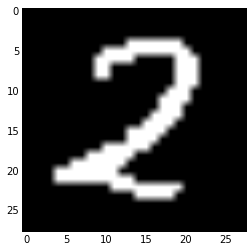

In [12]:
plt.imshow(X[0].reshape((28, 28)), cmap="gray")

In [5]:
X = X * 2 - 1 # make them between -1 and 1

In [6]:
X = shuffle(X)
train, test = train_test_split(range(X.shape[0]), test_size=0.25)

In [7]:
class MyBatchOptimizer(BatchOptimizer):
    
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        code, = self.model.encode(X[0:100])
        status["act_mean"] = code.mean()
        status["act_std"] = code.std()
        #self.learning_rate.set_value(np.array(self.learning_rate.get_value() * 0.9999, dtype="float32"))
        return status

## Model definition

In [35]:

def cross_entropy(truth, pred):
    return -(truth * T.log(pred) + (1 - truth) * T.log(1 - pred)).sum(axis=1).mean()

def cross_entropy_transformed(truth, pred):
    return (((truth - pred) ** 2).sum(axis=1)).mean()

def loss_representation(model):
    # l1 for weights
    layers = get_all_layers(model.nnet_to_z.outputs[0])
    return 0.001 * T.abs_(layers[1].W).sum()
    
def build_batch_optimizer():
    #learning_rate = theano.shared(np.array(0.01, dtype="float32"))
    learning_rate = 0.001
    batch_optimizer = MyBatchOptimizer(
        verbose=1,
        max_nb_epochs=100,
        batch_size=100,
        optimization_procedure=(updates.momentum, {"learning_rate": learning_rate,
                                              "momentum": 0.8
                                                   }),
        
    )
    batch_optimizer.learning_rate = learning_rate
    return batch_optimizer


def corrupted_masking_noise(rng, x, corruption_level):
    return rng.binomial(size=x.shape, n=1, p=1 - corruption_level) * x

def corrupted_salt_and_pepper(rng, x, corruption_level):
    selected = rng.binomial(size=x.shape, n=1, p=corruption_level, dtype=theano.config.floatX)
    return x * (1 - selected) + selected * rng.binomial(size=x.shape, n=1, p=0.5, dtype=theano.config.floatX)

rng = rng_mrg.MRG_RandomStreams()
 
def corruption_function(X):
    return corrupted_salt_and_pepper(rng, X, 0.5)
    
def build_model(i, o, corruption=False, batch_optimizer=None):
    if batch_optimizer is None:
        bo = build_batch_optimizer()
    else:
        bo = batch_optimizer
    x_in = layers.InputLayer((None, i))
    z_out = layers.DenseLayer(x_in, num_units=o,
                              nonlinearity=nonlinearities.tanh)
    x_to_z = LightweightModel([x_in], [z_out])

    z_in = layers.InputLayer((None, o))
    x_out = layers.DenseLayer(z_in, num_units=i,
                              nonlinearity=nonlinearities.tanh)
    z_to_x = LightweightModel([z_in], [x_out])
    noise_function = corruption_function if corruption is True else None
    aa = Autoencoder(x_to_z,
                     z_to_x,
                     batch_optimizer=bo,
                     noise_function=noise_function,
                     #loss_function_z=loss_representation,
                     loss_function=cross_entropy_transformed)
    aa.W = z_out.W
    aa.W_inv = x_out.W
    aa.batch_optimizer.layers = [z_out]
    return aa

def build_models(input_size):
    models = [
        build_model(input_size, 500, corruption=False),
        #build_model(500, 250),
        #build_model(250, 128),
    ]
    return models

In [38]:
models = build_models(X.shape[1])

## Training 

In [39]:
greedy_learn_with_validation(models, (train, test), -X)

  epoch    loss_std    loss_train    loss_valid    rec_error_train    rec_error_valid    act_mean    act_std
-------  ----------  ------------  ------------  -----------------  -----------------  ----------  ---------
      0     67.4337       86.1821       42.9932            42.3987            42.9932   0.0184905   0.788184
  epoch    loss_std    loss_train    loss_valid    rec_error_train    rec_error_valid    act_mean    act_std
-------  ----------  ------------  ------------  -----------------  -----------------  ----------  ---------
      1     4.95623       33.2822       26.8966            26.2953            26.8966    0.020854   0.775832
  epoch    loss_std    loss_train    loss_valid    rec_error_train    rec_error_valid    act_mean    act_std
-------  ----------  ------------  ------------  -----------------  -----------------  ----------  ---------
      2     2.47985       22.5298       19.7527            19.1401            19.7527   0.0193245   0.764746
  epoch    loss_std

KeyboardInterrupt: 

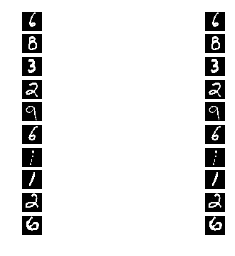

In [40]:
X_test = X[test]
r = np.arange(X_test.shape[0])
np.random.shuffle(r)
r = r[0:10]

X_hat = models[0].recover_function(X_test)
imshape = ((X_test.shape[0], w, h))

X_hat = X_hat.reshape(imshape)
X_ = X_test.reshape(imshape)
k = 0
for i in r:
    plt.subplot(len(r), 2, k + 1)
    plt.axis('off')
    plt.imshow(X_[i], cmap='gray')
    plt.subplot(len(r), 2, k + 2)
    plt.imshow(X_hat[i], cmap='gray')
    plt.axis('off')
    k += 2

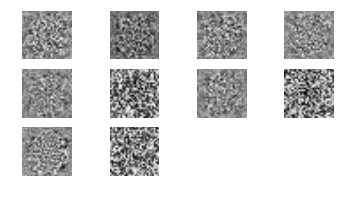

In [36]:
from lasagne.misc.plot_weights import grid_plot
W = models[0].W.get_value().T
W = W.reshape((W.shape[0], w, h))
W = W[0:10]
grid_plot(W, imshow_options={"cmap": "gray"})
plt.show()

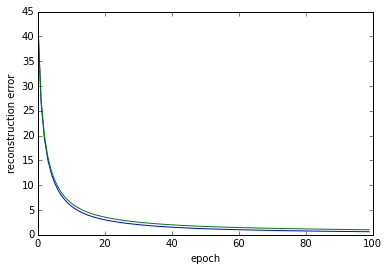

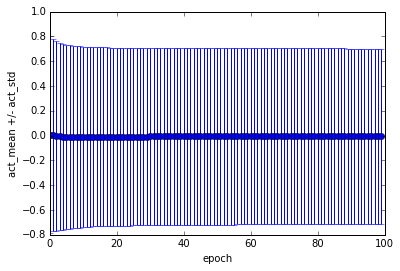

In [38]:
from lasagne.easy import get_stat

layer = 0
train_stat = get_stat("rec_error_train", models[layer].batch_optimizer.stats)
test_stat = get_stat("rec_error_valid", models[layer].batch_optimizer.stats)

plt.plot(train_stat)
plt.plot(test_stat)
plt.xlabel("epoch")
plt.ylabel("reconstruction error")
plt.show()

epoch = get_stat("epoch", models[layer].batch_optimizer.stats)
act_mean = get_stat("act_mean", models[layer].batch_optimizer.stats)
act_std = get_stat("act_std", models[layer].batch_optimizer.stats)

plt.errorbar(epoch, act_mean, yerr=act_std, fmt='-o')
plt.xlabel("epoch")
plt.ylabel("act_mean +/- act_std")